In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize
from scipy.optimize import leastsq
import pandas as pd
import lmfit

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



starting guess params from https://journals.aps.org/prb/pdf/10.1103/PhysRevB.101.144432

In [75]:
## dummy start
B20= -1e-2
B40= -1e-2
B43= -1e-2 
B60= -1e-2
B63= -1e-2
B66= -1e-2


## model 1
# B20 = -3.559e-2
# B40 = -3.849e-4
# B43 = -1.393e-2
# B60 = 3.154e-6
# B63 = -4.695e-6
# B66 = 3.3815e-5
## model 2
# B20= 3.114e-2
# B40= -4.718e-4
# B43= 1.259e-2 
# B60= 9.324e-7
# B63= 4.715e-5 
# B66= 2.011e-5

## from my ab plane fit
# B20= -0.04856891 
# B40= -3.6360e-04 
# B43= -0.01469852 
# B60=  3.1371e-06 
# B63= 2.8544e-06 
# B66= 4.2499e-05 

temperature = 10 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'
kBT = kB*temperature

# defining functions in 3d 

In [3]:
# functions we'll use to fit

def gaussian(x, amp,cen , wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def diagonalize(ionObj, ion, field, gx, gz): 
    # this assumes we apply the same field in x, y, z, which I think is fine for modelling
    axis = np.array([[1,0,0],[0,1,0],[0,0,1]])
    evalues = np.zeros((16,3)) # hard coded don't @ me bitch
    Jperp = -0.2e-3
    Jz = -2.5e-3
    q =6
    for a in axis: 
        Field = field *a
        JdotB = muB*(Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J))*gx + muB*(Field[2]*cef.Operator.Jz(ionObj.J))*gz
        H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
        ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
        evals = ionObj.eigenvalues
        evecs = ionObj.eigenvectors
        # JexpVals = np.zeros((len(evals),3))
        # for i, ev in enumerate(evecs):
        #     kev = cef.Ket(ev)
        #     JexpVals[i] =[np.real(kev*kev.Jx()),
        #                   np.real(kev*kev.Jy()),
        #                   np.real(kev*kev.Jz())]
        # Jhat = sum(JexpVals)/sum(sum(JexpVals)) #don't think this is correct, but it's fine for now i guess
        # JexpVals = JexpVals.T
        # perpPart = [[Jperp*j,0,0]  for j in JexpVals[0]]
        # zPart = [[0,0,Jz*j]  for j in JexpVals[2]]
        # Exxz = q/2*(Jperp*JexpVals[0]**2+Jz*JexpVals[2]**2) - q*np.dot(np.add(perpPart, zPart), Jhat)
        # # temp = q*np.dot(([Jperp*sum(JexpVals[0]),0.,0.]+[0,0,Jz*sum(JexpVals[2])]), Jhat)
        # Exxz[np.isnan(Exxz)] = 0 
        # newEvals = np.add(evals, Exxz)
        evals = [e*a for e in evals]
        evalues = np.add(evalues, evals)
    return evalues.T



In [4]:
def zeemanSplit(field, wavenum, B20, B40, B43, B60, B63, B66, gx, gz):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = np.ones(16)
    amp = amp.tolist()
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    axis = [1,2] # we only have data fro H||b and H||c
    try: # for the case we pass in a single B val
        fun =[]
        evals = diagonalize(ionObj, ion, field, gx, gz)
        for ax in axis: 
            minE = min(evals[ax])
            dE =[eval-minE for eval in evals[ax]] 
            Z = sum([np.exp(-Ei/kBT) for Ei in dE])
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = 16#len(dE)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE[j]-dE[i]
                    dE.append(temp)
                    amp.append(p[i])
            # so now we want to create a multi gaussian with centers at the eigenvalues
            wid = .5 # pulled this out my ass, .5cm-1 resolution roughly
            a = amp[0] #+ m[0]*field
            centers =dE 
            funAxis = gaussian(wavenum, a, centers[0]*meVToCm, wid)
            for i in range(len(centers[1:])):
                a = amp[i]
                funAxis += gaussian(wavenum, a, centers[i]*meVToCm, wid)
            fun.append(funAxis)
    except: 
        fun = []
        for ax in axis:
            funAxis = []
            for b in field:
                evals = diagonalize(ionObj, ion, b, gx, gz)
                minE = min(evals[ax])
                dE =[eval-minE for eval in evals[ax]] 
                Z = sum([np.exp(-Ei/kBT) for Ei in dE])
                p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
                numLines = len(dE)
                for i in range(1,numLines): 
                    for j in range(i+1, numLines):
                        temp = dE[j]-dE[i]
                        dE.append(temp)
                        amp.append(p[i])
                wid = .3
                a = amp[0]
                centers =dE 
                tempfun = 0
                for i in range(len(centers)):
                    tempfun += gaussian(wavenum, amp[i], centers[i]*meVToCm, wid)
                funAxis.append(tempfun)
                # print(len(centers))
            fun.append(funAxis)
    return fun



In [5]:

# functions we'll use to plot
def zeemanSplit3d(ionObj, ion, Field, gx, gz): 
    # ion input is cef.CFLevels.Bdict(ion,Bparams) type of variable
    # magnetic hamiltonian -> here we are using a magnetic dipole in a uniform, static field
    # this gives potential V = -mu.B
    # for our electrons, we can rewrite mu = gumBJ, with some prefactor
    # here J is our total ang mom. J = L+S
    JdotB = (muB*Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J))*gx + Field[2]*cef.Operator.Jz(ionObj.J)*gz
    #we've defined this as a CFLevels object
    # define just the CEF hamiltonian
    # H = ionObj.H # this is built into the CFLevels class. see pycrystal field doc
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # its just a sum of the stevens operators and the corresponding params
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 


def dummyModel(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA = []
    calcB = [] 
    calcC = []
    for B in Bfield: 
        calcA.append(zeemanSplit3d(ionObj, ion, [B, 0, 0])*meVToCm)
        calcB.append(zeemanSplit3d(ionObj, ion, [0, B, 0])*meVToCm)
        calcC.append(zeemanSplit3d(ionObj, ion, [0, 0, B])*meVToCm)
    calcA = np.array(calcA)
    calcB = np.array(calcB)
    calcC = np.array(calcC)
    return calcA.T, calcB.T, calcC.T
    
def fun(x, y, B20, B40, B43, B60, B63, B66):
    arr = []
    for field in x: 
        arr.append(zeemanSplit(field, y, B20, B40, B43, B60, B63, B66))
    return arr

def plotCalcZSpec(calcArr, Bfield): 
    plt.ion()
    for i in range(len(calcArr)):
        plt.plot(calcArr[i],Bfield,  'r', linestyle = '-', marker = ' ') 
    return

In [6]:
Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
ionObj = cef.CFLevels.Bdict(ion,Bparams)
gx = cef.LandeGFactor(ion)
gz = .05*gx#5.9
e = diagonalize(ionObj, ion, 1, gx, gz)

In [7]:
field =np.linspace(0,17,17*10)
wavenum =np.linspace(0,100,200)
ans = np.array(zeemanSplit(field, wavenum, B20, B40, B43, B60, B63, B66, gx, gz))

In [8]:
ans.shape

(2, 170, 200)

# now, let's load the data in 2D

In [9]:
bfname = '/Users/hopeless/Desktop/LeeLab/data/Maglab_IRMeasurement_June2022/ProcessingCode/Load1_TrimData/P2_CsEr_100-FIR_RAWAVG.dat'
cfname = '/Users/hopeless/Downloads/MikeOzerovsfiles_IR_June2022/2ndload_Jun03/P3_CsEr_NormAVG.dat'

normDataC = pd.read_csv(cfname, index_col=0, skiprows =1, header=0, delimiter=',')
normDataC = normDataC.drop(labels = '-1.1', axis=1)
rawData = pd.read_csv(bfname, index_col=0, skiprows=0, header=1)
normDataB = rawData.dropna(axis = 0)
# normDataB = normDataB.iloc[0:4000, :]
normDataB = normDataB.dropna(axis=1)
normDataC = normDataC.dropna(axis=0)
normDataB = normDataB.drop(labels = '-1.1', axis=1)

normSpec = rawData['0.001']/max(rawData['0.001'])
avgSpec = normSpec
for column in normDataB.columns: 
    # in a dataframe, column is a key
    normDataB[column] = max(normDataB[column]) -normDataB[column]
    normDataB[column] = normDataB[column]/(max(normDataB[column])) -normSpec
    avgSpec = avgSpec + normDataB[column]

len(rawData.columns)
for column in normDataB.columns: 
    normDataB[column] = normDataB[column]-avgSpec/len(rawData.columns)
    normDataB[column] = normDataB[column]-(sum(normDataB[column])/len(normDataB[column]))
normDataB = normDataB.drop(labels='0.001', axis=1)


In [10]:
for index in normDataB.index:
    if index<20: 
        normDataB = normDataB.drop(labels=index , axis = 0)
    if index>110:
        normDataB = normDataB.drop(labels=index , axis = 0)

for index in normDataC.index:
    if index<20: 
        normDataC = normDataC.drop(labels=index , axis = 0)
    if index>110:
        normDataC = normDataC.drop(labels=index , axis = 0)

In [11]:
normDataC = (normDataC - 5.4)*-1
normDataC = (normDataC/5.4)*2

In [12]:
normDataB = normDataB/0.594

In [13]:
for index in normDataC.index:
    for col in normDataC.columns: 
        if normDataC.loc[index, col] <1.65: 
            normDataC.loc[index, col] = 0

In [14]:
for index in normDataB.index:
    for col in normDataB.columns: 
        if normDataB.loc[index, col] <0: 
            normDataB.loc[index, col] = 0

In [15]:
normDataC = normDataC/2
# normDataB = normDataB*2/.648

In [16]:
temp = normDataC


In [17]:
len(normDataC.columns)

71

In [18]:
labelArr = ['0.001','2.25', '2.749', '3.25', '3.75', '4.249', '4.749', '5.249', '5.75',
       '6.25', '6.749', '7.249', '7.75', '8.249', '8.75', '9.25', '9.749',
       '10.25', '10.75', '11.249', '11.75', '12.249', '12.75', '13.25',
       '13.75', '14.25', '14.75', '15.249', '15.749', '16.25', '16.75',
       '17.252']
temp = temp.drop(labels = labelArr, axis=1)

In [19]:
len(normDataB.columns)

39

In [20]:
temp = temp.to_numpy()
b = normDataB.to_numpy()

In [21]:
# lets get bfield + wavenum arrays from the dataframe
Bfield = [float(b) for b in normDataB.columns.values]
wavenums = [float(i) for i in normDataB.index.values]

In [22]:
data = np.empty((len(wavenums),len(Bfield),2))
for i in range(len(b)):
    for j in range(len(temp[1])):
        data[i][j] = [b[i][j], temp[i][j]]

In [23]:
data.shape

(2987, 39, 2)

In [24]:
data = data.T

In [68]:
model = lmfit.Model(zeemanSplit, independent_vars=['field', 'wavenum'])
paramsC = model.make_params()

paramsC['B20'].set(value= B20)
paramsC['B40'].set(value= B40)
paramsC['B43'].set(value= B43)
paramsC['B60'].set(value= B60)
paramsC['B63'].set(value= B63)
paramsC['B66'].set(value= B66)
paramsC['B20'].set(vary= True)
paramsC['B40'].set(vary= True)
paramsC['B43'].set(vary= True)
paramsC['B60'].set(vary= True)
paramsC['B63'].set(vary= True)
paramsC['B66'].set(vary= True)
# paramsC['gz'].set(value= 5.9)
# paramsC['gx'].set(value= 5.4) # from alan's paper, really don't fkn match with my data??
paramsC['gz'].set(value= 1.2, vary=False)
paramsC['gx'].set(value= 1.2, vary=False) 
# Bfield = [float(b) for b in normDataB.index.values]
# wavenums = [float(i) for i in normDataB.columns.values]


In [59]:
len(Bfield)

39

In [69]:
resultC = model.fit(data, field=Bfield, wavenum=wavenums, params =paramsC, verbose=True, calc_covar=True)#, method = 'L-BFGS-B')

In [76]:
print(resultC.fit_report())

[[Model]]
    Model(zeemanSplit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2248
    # data points      = 232986
    # variables        = 6
    chi-square         = 28575.2391
    reduced chi-square = 0.12265104
    Akaike info crit   = -488894.627
    Bayesian info crit = -488832.474
    R-squared          = -1.99575908
[[Variables]]
    B20: -3.1312e-04 +/- 3.0732e-06 (0.98%) (init = -0.0003149)
    B40:  6.1194e-06 +/- 2.2784e-08 (0.37%) (init = -6.0959e-06)
    B43: -2.0519e-05 +/- 1.0121e-06 (4.93%) (init = -2.0377e-05)
    B60:  7.8123e-07 +/- 1.6253e-10 (0.02%) (init = 7.8158e-07)
    B63:  2.9575e-06 +/- 8.2070e-09 (0.28%) (init = 2.9589e-06)
    B66:  1.5871e-06 +/- 3.5931e-09 (0.23%) (init = 1.5856e-06)
    gx:   1.2 (fixed)
    gz:   1.2 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(B20, B60) = +0.4981
    C(B60, B63) = -0.4370
    C(B20, B40) = +0.4336
    C(B60, B66) = -0.3606
    C(B20, B63) = -0.2248
    C(B20, B66

In [71]:
fieldArr = np.linspace(0,17,360)
waveArr = np.linspace(0,400,2000)
res = zeemanSplit(fieldArr, waveArr, resultC.params['B20'], resultC.params['B40'], 
                   resultC.params['B43'], resultC.params['B60'], 
                   resultC.params['B63'], resultC.params['B66'], float(resultC.params['gx']), float(resultC.params['gz']))

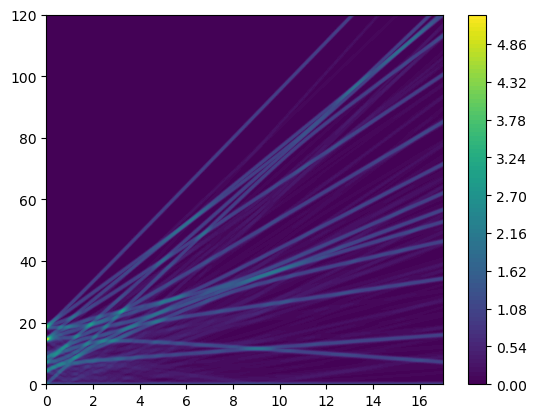

In [72]:
plt.contourf(fieldArr, waveArr, np.array(res[1]).T,100)
plt.ylim(0,120)
plt.colorbar()
# plt.ylim(0,20)
# plt.xlim(0,8)

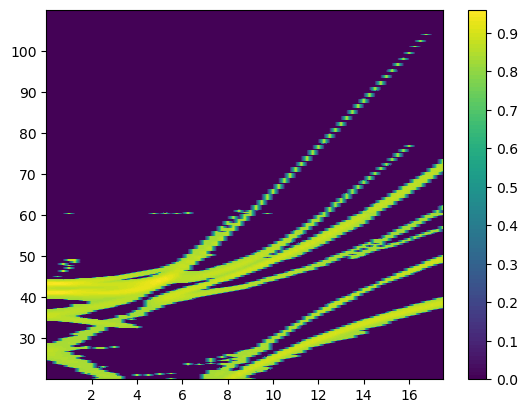

In [73]:
BfieldC = [float(b) for b in normDataC.columns.values]
wavenumsC = [float(i) for i in normDataC.index.values]
plt.contourf(BfieldC, wavenumsC, normDataC, 100)
plt.colorbar()
# plt.clim(1.65,2)

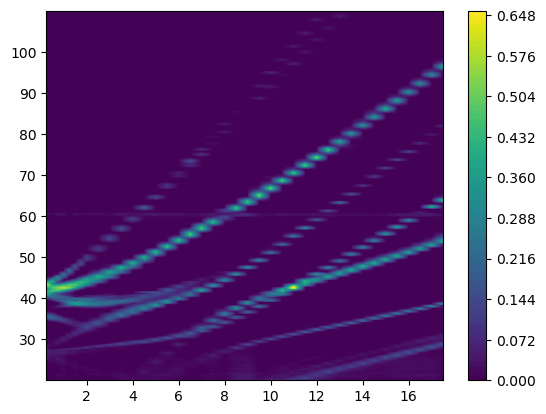

In [32]:
BfieldB = [float(b) for b in normDataB.columns.values]
wavenumsB = [float(i) for i in normDataB.index.values]
plt.contourf(BfieldB, wavenumsB, normDataB, 100)
plt.colorbar()
# plt.clim(-0.05,.7)

In [33]:
def zeemanSplitLines(field, wavenum, B20, B40, B43, B60, B63, B66, gx, gz):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = np.ones(16)
    amp = amp.tolist()
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    axis = [1,2] # we only have data fro H||b and H||c
    axArr = [[1,0,0],[0,1,0],[0,0,1]]
    try: # for the case we pass in a single B val
        fun =[]
        evals = diagonalize(ionObj, ion, field, gx, gz)
        for ax in axis: 
            minE = min(evals[ax])
            dE =[eval-minE for eval in evals[ax]] 
            Z = sum([np.exp(-Ei/kBT) for Ei in dE])
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = 16#len(dE)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE[j]-dE[i]
                    dE.append(temp)
                    amp.append(p[i])
            # so now we want to create a multi gaussian with centers at the eigenvalues
            wid = .5 # pulled this out my ass, .5cm-1 resolution roughly
            a = amp[0] #+ m[0]*field
            centers =dE 
            funAxis = gaussian(wavenum, a, centers[0]*meVToCm, wid)
            for i in range(len(centers[1:])):
                a = amp[i]
                funAxis += gaussian(wavenum, a, centers[i]*meVToCm, wid)
            fun.append(funAxis)
    except: 
        fun = []
        for b in field:
            evals = diagonalize(ionObj, ion, b, gx, gz)
            for ax in axis:
                evals = diagonalize(ionObj, ion, b, gx, gz)
                minE = min(evals[ax])
                dE =[eval-minE for eval in evals[ax]] 
                Z = sum([np.exp(-Ei/kBT) for Ei in dE])
                p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
                numLines = len(dE)
                for i in range(1,numLines): 
                    for j in range(i+1, numLines):
                        temp = dE[j]-dE[i]
                        dE.append(temp)
                        amp.append(p[i])
                # print(len(centers))
            fun.append(dE)
    return fun


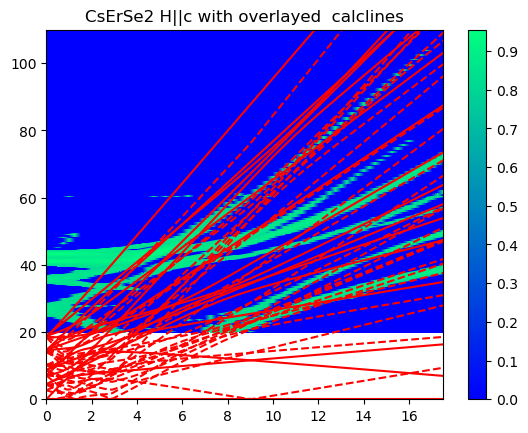

In [74]:
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

result = resultC
arrC = zeemanSplitLines(fieldArr, waveArr, resultC.params['B20'], resultC.params['B40'], 
                   resultC.params['B43'], resultC.params['B60'], 
                   resultC.params['B63'], resultC.params['B66'], 1.2, 1.2)

# ampC, arrC = zeemanSplitLines(fieldArr, B20, B40, B43, B60, B63, B66)
arrC = np.array(arrC)
arrC = arrC*meVToCm
arrC = arrC.T


plt.contourf(BfieldC, wavenumsC, normDataC,200, cmap='winter')
plt.xlim(0,17.5)
plt.ylim(0,110)
# plt.clim(0, .7)
plt.colorbar()
plt.title('CsErSe2 H||c with overlayed  calclines')
for i in range(40):
    if i<16: 
        plt.plot(fieldArr, arrC[i], 'r')
    if i>=16: 
        plt.plot(fieldArr, arrC[i], 'r--')

In [35]:
arrC.shape

(121, 100)

In [36]:
arrC[1].shape

(100,)

In [37]:
arrC = arrC.T